## <b>Описание данных и задания </b>

### <b>Техническое задание </b>

#### <b>Описание</b>

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

#### <b>Цель</b>

Предсказать вероятность покупки в течение 90 дней

#### <b>Задачи</b>

<br>● Изучить данные
<br>● Разработать полезные признаки
<br>● Создать модель для классификации пользователей
<br>● Улучшить модель и максимизировать метрику roc_auc
<br>● Выполнить тестирование

### <b>Описание данных</b>

#### <b>apparel-purchases</b>

<br>Данные о покупках клиентов по дням и по товарам. В каждой записи покупка
определенного товара, его цена, количество штук. Крастко - история покупок.
<br>● client_id - идентификатор клиента
<br>● quantity - количество единиц товара
<br>● price - цена товара
<br>● category_ids - идентификаторы категорий
<br>● date - дата покупки
<br>● message_id - идентификатор сообщения из рассылки

#### <b>apparel-messages</b>

<br>Рассылки, которые были отправлены клиентам из таблицы покупок. История рекламных рассылок.
<br>● bulk_campaign_id - идентификатор рассылки
<br>● client_id - идентификатор клиента
<br>● message_id - идентификатор сообщения
<br>● event - действие с сообщением (отправлено, открыто, покупка…)
<br>● channel - канал рассылки
<br>● date - дата действия
<br>● created_at - дата-время полностью

#### <b>target</b>

<br>Совершит ли клиент покупку в течение следующих 90 дней
<br>● client_id - идентификатор пользователя
<br>● target - целевой признак


#### <b>full_campaign_daily_event</b>

<br>Агрегация общей базы рассылок по дням и типам событий. 
<br>● bulk_campaign_id - идентификатор рекламной кампании
<br>● client_id - идентификатор пользователя
<br>● message_id - идентификатор сообщений
<br>● event - тип действия
<br>● channel - канал рассылки
<br>● date - дата рассылки
<br>● created_at - точное время создания сообщения

#### <b>full_campaign_daily_event_channel</b>

<br>Агрегация по дням с учетом событий и каналов рассылки
<br>● date - дата
<br>● bulk_campaign_id - идентификатор рассылки
<br>● count_event*_channel* - общее количество каждого события по каналам
<br>● nunique_event*_channel* - количество уникальных client_id по событиям и каналам


## <b>Импорт библиотек и функций</b>

#### <b>Библиотеки</b>

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Загрузка и обработка данных.
import pandas as pd 
import numpy as np
from datetime import datetime

#Визуализация данных
from matplotlib import pyplot as plt
import seaborn as sns, numpy as np
import matplotlib.pyplot as mp
from phik.report import plot_correlation_matrix

#Преобразование данных
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

#Модели
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

#Прочее
import warnings
warnings.filterwarnings('ignore')

C:\Users\yurpa\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore


#### <b>Функции</b>

In [3]:
line = '-'*132

#Информация о таблице
def percentage_passes (dataset):
    print(dataset.info())
    print(line)
    print('Количество пропущенных значений таблицы:')
    for col in dataset.columns:
        datcol = np.mean(dataset[col].isnull())
        print(col, datcol)  
        
    print(line)
    print('Количество дубликатов -', dataset.duplicated().sum())

#Преобразование таблиц
def table (data,data_1,values,index,aggfunc):
    datas = data_1.pivot_table(values=values, index=index, aggfunc=aggfunc)
    datas = datas.reset_index()
    
    def merg (d_1, d_2, ind):
        d_1 = pd.merge(d_1, d_2, on=ind)
        return d_1
        
    data = merg(data, datas, index)
    return data

#Визуализация данных
def data_analysis (variable, column):
    means = variable[column].mean()
    medians = variable[column].median()
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].axvline(x=means, color='green')
    axes[0].axvline(x=medians, color='red')
    axes[0].legend(['Среднее значение - {:.2f}'.format(means),
                    'Медианное значение - {:.2f}'.format(medians)])
    axes[0].set_title(f'Гистограмма для - {column}', fontsize=15)
    axes[0].set_ylabel('Количество', fontsize=10)
    
    sns.histplot(variable, bins=20, kde=True, ax=axes[0], x=column)
    axes[1].set_title(f'График ящик с усами для - {column}', fontsize=15)
    sns.boxplot(data=variable, ax=axes[1], y=column)
    axes[1].set_ylabel(column, fontsize=10)
    plt.show()
    
#------------------------------------------------------------------------------------------------------------------------------------
def direct_diagram(variable, column):
    display(variable[column].unique())
    plt.figure(figsize=(8,6))
    plot = sns.countplot(y=column, data=variable)
    plot.set_title(f'Рапределение по - {column}', fontsize=15)
    plot.set_xlabel('Количество', fontsize=10)
    plt.show()

## <b>Загрузка и изучение данных</b>

#### <b>apparel-purchases.csv</b>

In [4]:
purchases = pd.read_csv('apparel-purchases.csv')

In [5]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [6]:
percentage_passes(purchases)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB
None
------------------------------------------------------------------------------------------------------------------------------------
Количество пропущенных значений таблицы:
client_id 0.0
quantity 0.0
price 0.0
category_ids 0.0
date 0.0
message_id 0.0
------------------------------------------------------------------------------------------------------------------------------------
Количество дубликатов - 73020


<b>purchases</b>
<br>Таблица имеет - 202208 строк и 6 столбцов. 
<br>Пропусков нет.
<br>Количество дубликатов - 73020

#### <b>apparel-messages.csv</b>

In [7]:
messages = pd.read_csv('apparel-messages.csv')

In [8]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [9]:
percentage_passes(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB
None
------------------------------------------------------------------------------------------------------------------------------------
Количество пропущенных значений таблицы:
bulk_campaign_id 0.0
client_id 0.0
message_id 0.0
event 0.0
channel 0.0
date 0.0
created_at 0.0
------------------------------------------------------------------------------------------------------------------------------------
Количество дубликатов - 48610


<b>messages</b>
<br>Таблица имеет - 12739798 строк и 7 столбцов. 
<br>Пропусков нет.
<br>Количество дубликатов - 48610

#### <b>apparel-target_binary.csv</b>

In [10]:
target = pd.read_csv('apparel-target_binary.csv')

In [11]:
target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [12]:
percentage_passes(target)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
None
------------------------------------------------------------------------------------------------------------------------------------
Количество пропущенных значений таблицы:
client_id 0.0
target 0.0
------------------------------------------------------------------------------------------------------------------------------------
Количество дубликатов - 0


<b>target</b>
<br>Таблица имеет - 49849 строк и 2 столбца. 
<br>Пропусков нет.
<br>Дубликатов нет.

#### <b>full_campaign_daily_event.csv</b>

In [13]:
full_campaign_daily_event = pd.read_csv('full_campaign_daily_event.csv')

In [14]:
full_campaign_daily_event.head()

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [15]:
percentage_passes(full_campaign_daily_event)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

<b>full_campaign_daily_event</b>
<br>Таблица имеет - 131072 строк и 24 столбцов. 
<br>Пропусков нет.
<br>Дубликатов нет.

#### <b>full_campaign_daily_event_channel.csv</b>

In [16]:
full_campaign_daily_event_channel = pd.read_csv('full_campaign_daily_event_channel.csv')

In [17]:
full_campaign_daily_event_channel.head()

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
percentage_passes(full_campaign_daily_event_channel)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

<b>full_campaign_daily_event_channel</b>
<br>Таблица имеет - 131072  строк и 36 столбцов. 
<br>Пропусков нет.
<br>Дубликатов нет.

## <b>Обработка дынных</b>

Удалю дубликаты.

In [19]:
purchases = purchases.drop_duplicates()
print(f'Количество дубликатов в "purchases" - {purchases.duplicated().sum()}')

messages = messages.drop_duplicates()
print(line)
print(f'Количество дубликатов в "messages" - {messages.duplicated().sum()}')

Количество дубликатов в "purchases" - 0
------------------------------------------------------------------------------------------------------------------------------------
Количество дубликатов в "messages" - 0


Нужно создать таблицу со всеми столбцами. Так как имеется отдельная таблица <b>target</b> то все столбцы буду добавлять к ней. 

In [20]:
print(f"Уникальных client_id в 'target' -  {len(target['client_id'].unique())}")
print(line)
print(f"Уникальных client_id в 'purchases' -  {len(purchases['client_id'].unique())}")
print(line)
print(f"Уникальных client_id в 'messages' -  {len(messages['client_id'].unique())}")
print(line)
print(f"Уникальных client_id в 'messages' больше на -  {len(messages['client_id'].unique()) - len(purchases['client_id'].unique())} значений")

Уникальных client_id в 'target' -  49849
------------------------------------------------------------------------------------------------------------------------------------
Уникальных client_id в 'purchases' -  49849
------------------------------------------------------------------------------------------------------------------------------------
Уникальных client_id в 'messages' -  53329
------------------------------------------------------------------------------------------------------------------------------------
Уникальных client_id в 'messages' больше на -  3480 значений


В таблице <b>messages</b> уникальных <b>client_id</b> больше. Это не страшно так-как таблицы будут фильтроваться и соедеиняться по <b>client_id</b> в таблице <b>target</b>

Добавлю в <b>target</b> значения из <b>purchases</b>.

In [21]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [22]:
#Количество всех товаров для каждого пользователя.
target = table(target,purchases,'quantity','client_id', 'sum')

#Сумма всех товаров для каждого пользователя.
target = table(target,purchases,'price','client_id', 'sum')

#Средняя сумма всех заказов.
target = table(target,purchases,'price','client_id', 'mean')

#Самая частая категория.
purchases['category_ids'] = purchases['category_ids'].str.replace('[', '').str.replace(']', '').str.replace(" ", '').str.replace("'", '')
purchases['category_ids'] = purchases['category_ids'].str.split(",", expand=True)
target = table(target,purchases,'category_ids','client_id', 'max')

#Количество дней между первой и последней покупкой.
date_1 = table(target,purchases,'date','client_id', 'max')
date_1 = pd.to_datetime(date_1['date']).dt.date
date_1 = pd.to_datetime(date_1,  format='%Y-%m-%d')

date_2 = table(target,purchases,'date','client_id', 'min')
date_2 = pd.to_datetime(date_2['date']).dt.date
date_2 = pd.to_datetime(date_2,  format='%Y-%m-%d')

target['number_days'] = (date_1 - date_2).dt.days

#Переименую столбцы.
target.rename(columns={'price_x':'price','price_y': 'price_mean'}, inplace=True)

При изучении файла узнал что в столбце <b>category_ids</b>. есть пустые значения. Обработаю их и переведу столбцец в float

In [23]:
target.loc[target['category_ids'] == 'None', 'category_ids'] = '99'
target.loc[target['category_ids'] == '', 'category_ids'] = '999'

target['category_ids'] = target[('category_ids')].values.astype("int")

In [24]:
target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   client_id     49849 non-null  int64  
 1   target        49849 non-null  int64  
 2   quantity      49849 non-null  int64  
 3   price         49849 non-null  float64
 4   price_mean    49849 non-null  float64
 5   category_ids  49849 non-null  int32  
 6   number_days   49849 non-null  int64  
dtypes: float64(2), int32(1), int64(4)
memory usage: 2.9 MB


Теперь добавлю в <b>target</b> значения из <b>messages</b>.

In [25]:
print(f"Неявные дубликаты столбца 'event' - {messages['event'].unique()}")
print(line)
print(f"Неявные дубликаты столбца 'channel' - {messages['channel'].unique()}")

Неявные дубликаты столбца 'event' - ['open' 'click' 'purchase' 'send' 'unsubscribe' 'hbq_spam' 'hard_bounce'
 'subscribe' 'soft_bounce' 'complain' 'close']
------------------------------------------------------------------------------------------------------------------------------------
Неявные дубликаты столбца 'channel' - ['email' 'mobile_push']


In [26]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [27]:
#Добавлю количество уведомлений для каждого клиента.
messages['van'] = 1
messages_channel = messages.pivot_table(values='van', index='client_id', columns='channel', aggfunc='sum',fill_value = 0)
target = pd.merge(target,messages_channel, on = 'client_id')

In [28]:
#Добавлю количество действий на каждый канал рассылки для каждого клиента.

#Создам сводную таблицу для email.
messages_email = messages[messages['channel'] == 'email']
messages_email = messages_email.pivot_table(values='van', index='client_id', columns='event', aggfunc='sum',fill_value = 0)
messages_email.rename(columns={'click': 'click_emai', 'complain': 'complain_email','hard_bounce':'hard_bounce_email','hbq_spam':'hbq_spam_email','open':'open_email','purchase':'purchase_email','send':'send_email','soft_bounce':'soft_bounce_email','subscribe':'subscribe_email','unsubscribe':'unsubscribe_email'}, inplace=True)
messages_email = messages_email.reset_index()

#Создам сводную таблицу для mobile_push.
messages_push = messages[messages['channel'] == 'mobile_push']
messages_push = messages_push.pivot_table(values='van', index='client_id', columns='event', aggfunc='sum',fill_value = 0)
messages_push.rename(columns={'click': 'click_push', 'complain': 'complain_push','hard_bounce':'hard_bounce_push','hbq_push':'hbq_spam_push','open':'open_push','purchase':'purchase_push','send':'send_push','soft_bounce':'soft_bounce_push','subscribe':'subscribe_push','unsubscribe':'unsubscribe_push'}, inplace=True)
messages_email = messages_email.reset_index()

#Объеденю таблицы.
messages_email_push = pd.merge(messages_email, messages_push, on ='client_id',  how="outer")
messages_email_push = messages_email_push.fillna(0)

messages_email_push = messages_email_push.drop('index', axis = 1)
messages_email_push.head()

event,client_id,click_emai,complain_email,hard_bounce_email,hbq_spam_email,open_email,purchase_email,send_email,soft_bounce_email,subscribe_email,unsubscribe_email,click_push,close,hard_bounce_push,open_push,purchase_push,send_push,soft_bounce_push
0,1515915625468060902,10.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1515915625468061003,5.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1515915625468061099,8.0,0.0,0.0,0.0,17.0,0.0,157.0,0.0,0.0,0.0,0.0,0.0,2.0,34.0,0.0,58.0,0.0
3,1515915625468061170,16.0,0.0,0.0,0.0,19.0,3.0,164.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,79.0,0.0
4,1515915625468061514,12.0,0.0,0.0,0.0,17.0,1.0,150.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
target = pd.merge(target, messages_email_push, on ='client_id')

In [30]:
target.head()

,client_id,target,quantity,price,price_mean,category_ids,number_days,email,mobile_push,click_emai,...,soft_bounce_email,subscribe_email,unsubscribe_email,click_push,close,hard_bounce_push,open_push,purchase_push,send_push,soft_bounce_push
0,1515915625468060902,0,5,4795.0,959.000000,4,0,177,0,10.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1515915625468061003,1,6,14135.0,2355.833333,4,0,165,0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1515915625468061099,0,1,299.0,299.000000,4,0,182,94,8.0,...,0.0,0.0,0.0,0.0,0.0,2.0,34.0,0.0,58.0,0.0
3,1515915625468061100,0,1,1049.0,1049.000000,4,0,0,428,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,157.0,1.0,267.0,1.0
4,1515915625468061170,0,8,14102.0,1762.750000,4,83,202,91,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,79.0,0.0


In [31]:
percentage_passes(target)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41982 entries, 0 to 41981
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_id          41982 non-null  int64  
 1   target             41982 non-null  int64  
 2   quantity           41982 non-null  int64  
 3   price              41982 non-null  float64
 4   price_mean         41982 non-null  float64
 5   category_ids       41982 non-null  int32  
 6   number_days        41982 non-null  int64  
 7   email              41982 non-null  int64  
 8   mobile_push        41982 non-null  int64  
 9   click_emai         41982 non-null  float64
 10  complain_email     41982 non-null  float64
 11  hard_bounce_email  41982 non-null  float64
 12  hbq_spam_email     41982 non-null  float64
 13  open_email         41982 non-null  float64
 14  purchase_email     41982 non-null  float64
 15  send_email         41982 non-null  float64
 16  soft_bounce_email  419

<b>Итог обработки данных:</b> 
<br>Удалены дубликаты в <b>purchases</b> и <b>messages</b> 
<br>В таблицу <b>target</b> были добавлены столбцы:
<br>● quantity - количество всех товаров для каждого пользователя
<br>● price - сумма всех товаров для каждого пользователя
<br>● price_mean - средняя сумма всех товаров для каждого пользователя
<br>● category_ids - самая частая категория для каждого клиента
<br>● number_days - количество дней между первой и последней покупкой
<br>● email - количество уведомлений, отправленных в виде эмейла
<br>● mobile_push - количество уведомлений, отправленных в виде пуш
<br>● Агрегация <b>client_id</b>  дням с учетом событий и каналов рассылки

## <b>Исследовательский анализ</b>

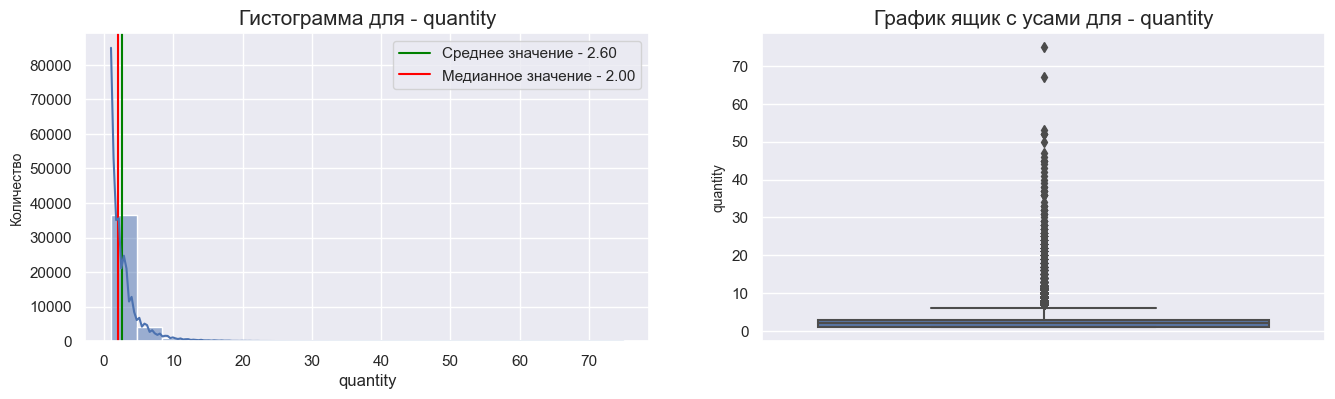

In [32]:
data_analysis(target, 'quantity')

В основном клиенты купили меньше 10 товаров

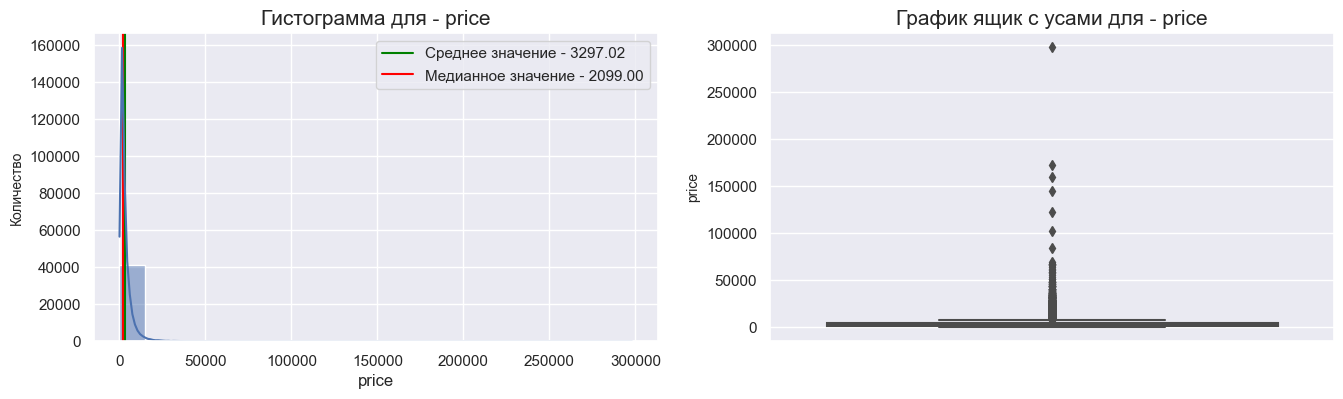

In [33]:
data_analysis(target, 'price')

In [34]:
tp = target[target['price'] < 30000]

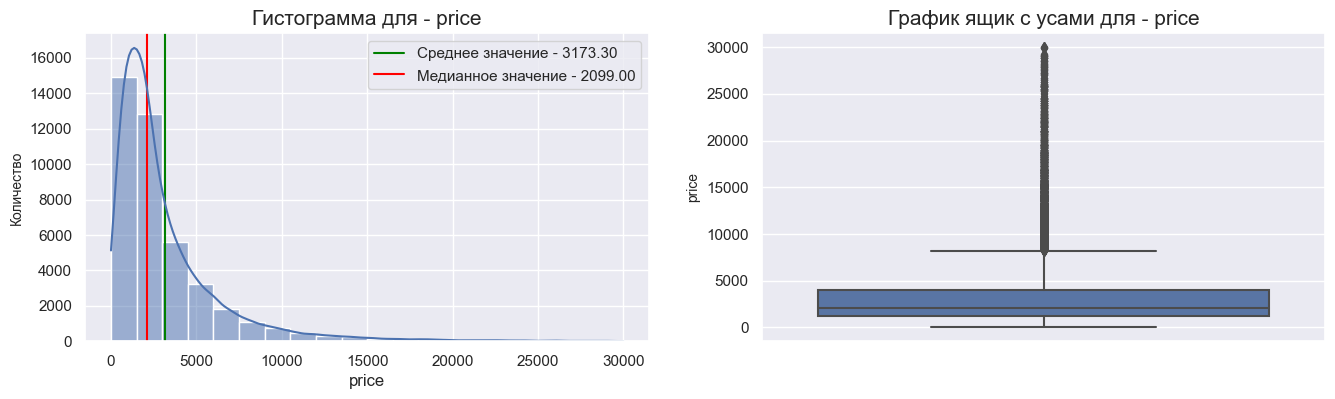

In [35]:
data_analysis(tp, 'price')

Стоимость всех заказов редко привышает 5000р.

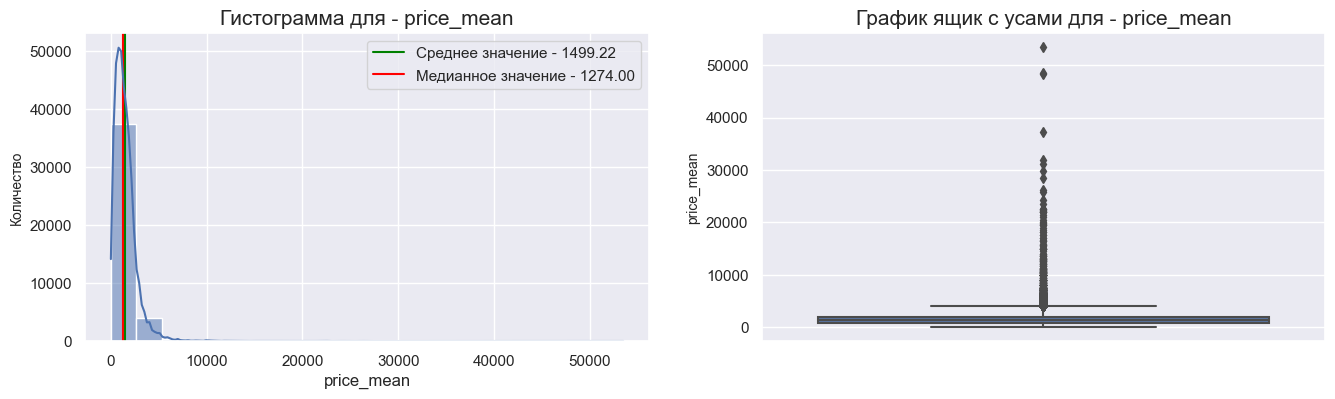

In [36]:
data_analysis(target, 'price_mean')

In [37]:
tpm = target[target['price'] < 10000]

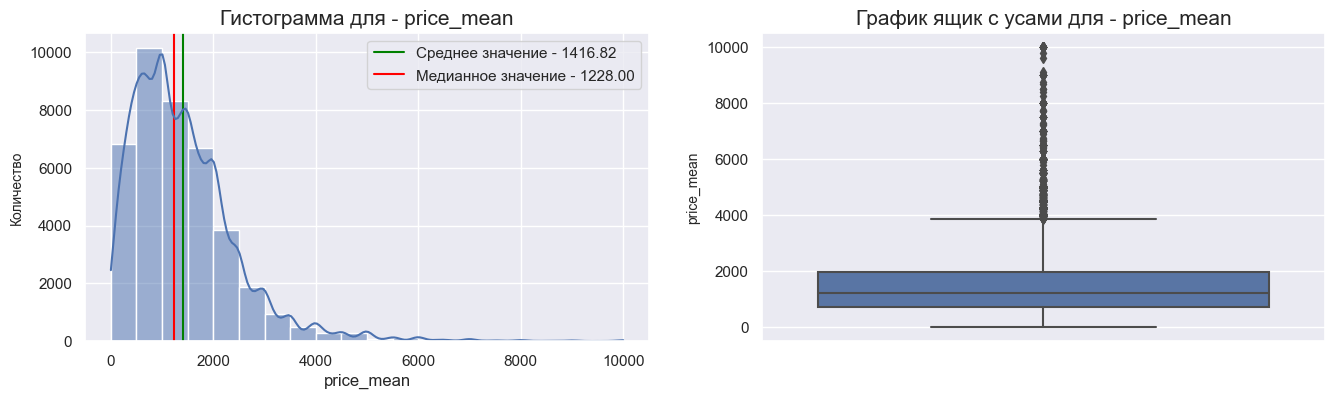

In [38]:
data_analysis(tpm, 'price_mean')

Обычно стоимость всех заказов около 2000р.

array([   4, 5562, 6060,    2, 5963,   99,  999])

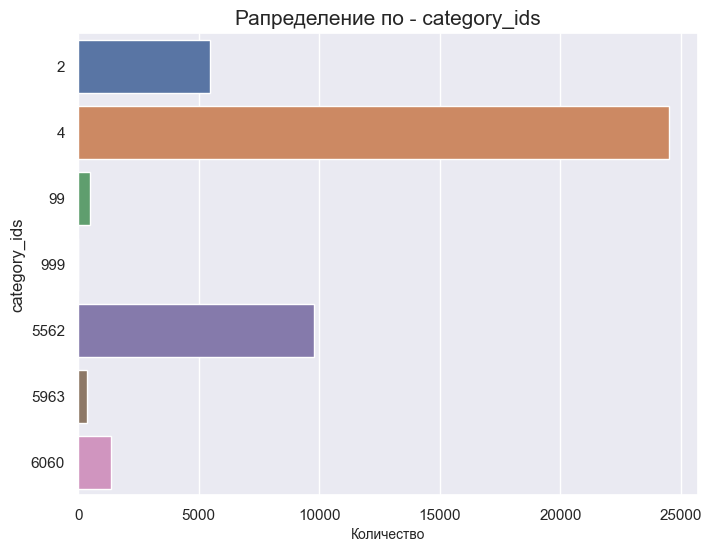

In [39]:
direct_diagram(target, 'category_ids')

3 значения самых популярных категорий - 4, 5562, 2

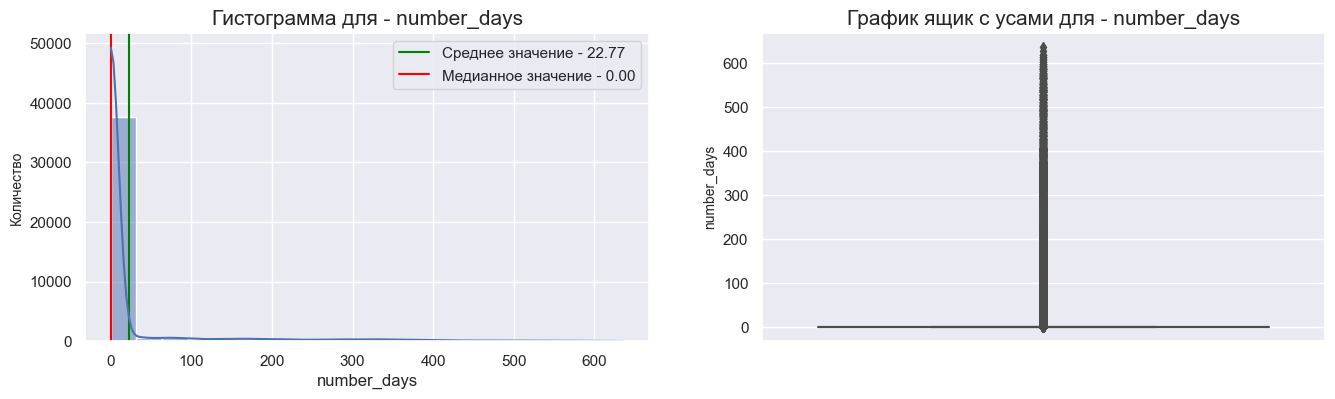

In [40]:
data_analysis(target, 'number_days')

In [41]:
tnd = target[target['number_days'] <= 10]

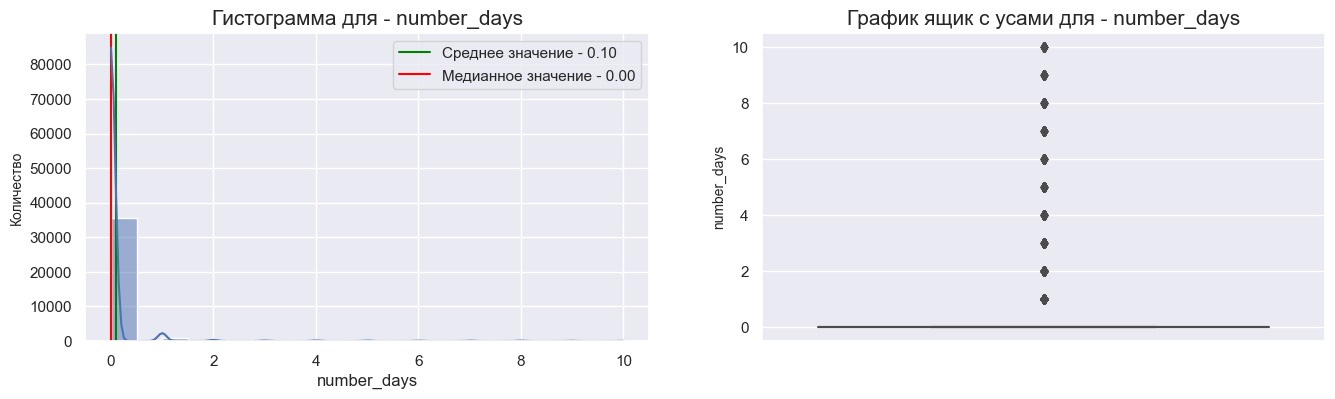

In [42]:
data_analysis(tnd, 'number_days')

Количество дней между двумя датами очень-очень редко привышает 2

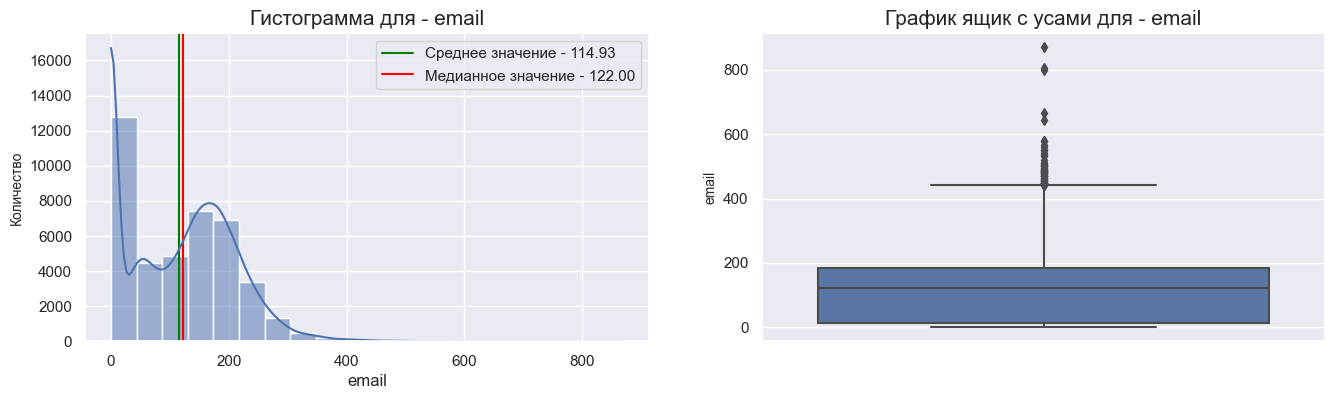

In [43]:
data_analysis(target, 'email')

Количество отправленных эмейл уведомлений практически не превышает 200 уведомлений

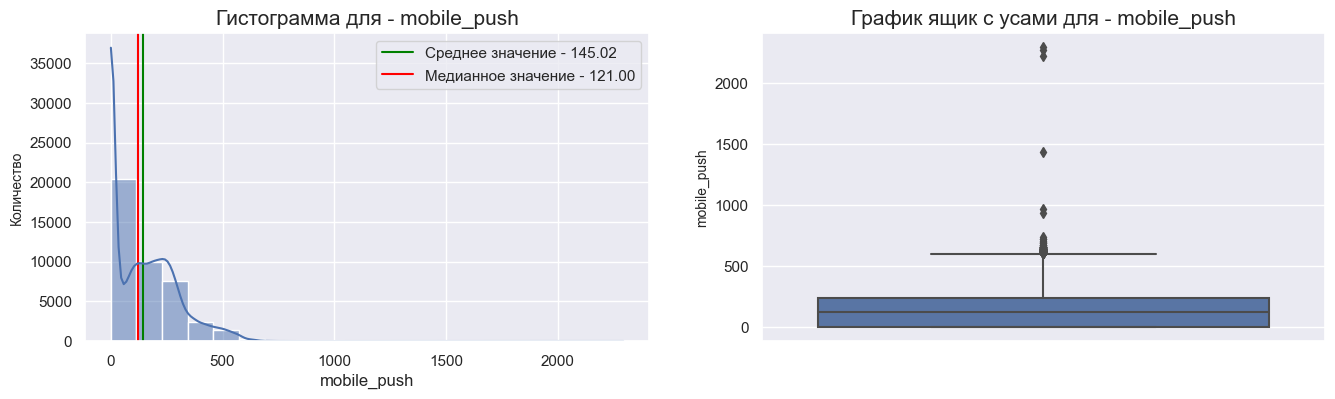

In [44]:
data_analysis(target, 'mobile_push')

Количество отправленных пуш уведомлений практически не превышает 200 уведомлений

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

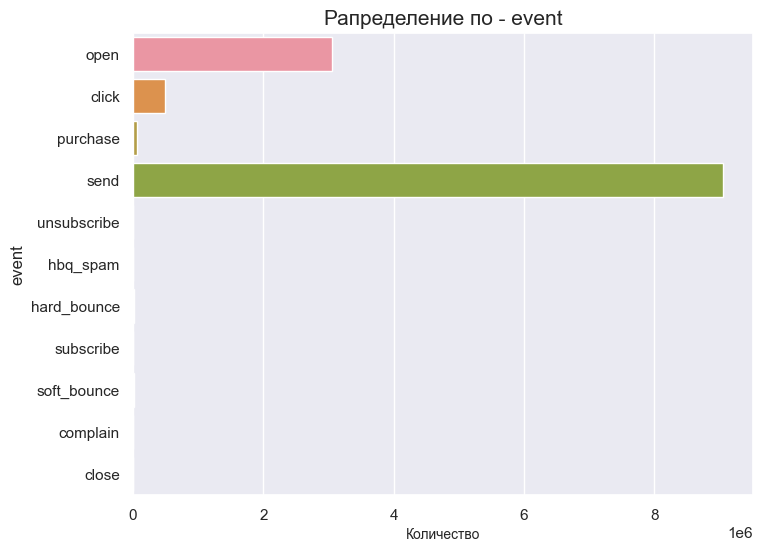

In [45]:
direct_diagram(messages, 'event')

Самое частое действие которое пользователи делают с уведомлениями - send

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'subscribe', 'soft_bounce', 'hard_bounce', 'complain'],
      dtype=object)

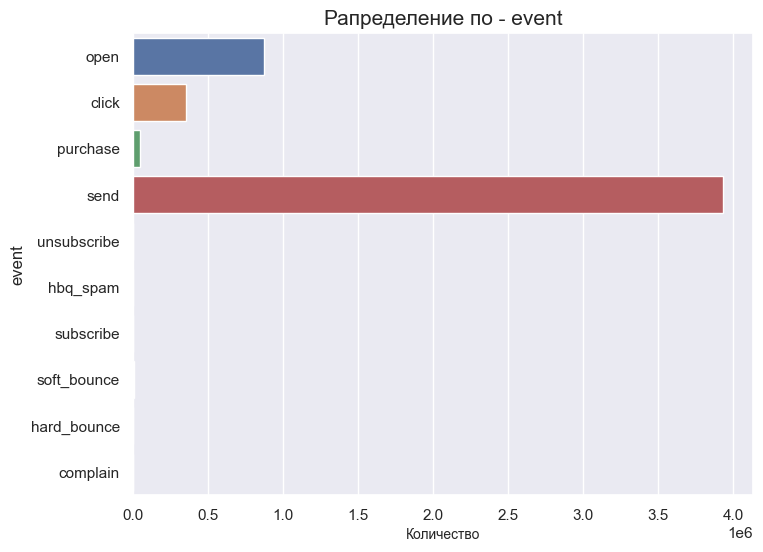

In [46]:
messages_email_diagram = messages[messages['channel'] == 'email']

direct_diagram(messages_email_diagram, 'event')

3 самые частыe действия которые пользователи делают с эмейл уведомлениями - send, open, click

array(['click', 'send', 'hard_bounce', 'open', 'purchase', 'close',
       'soft_bounce'], dtype=object)

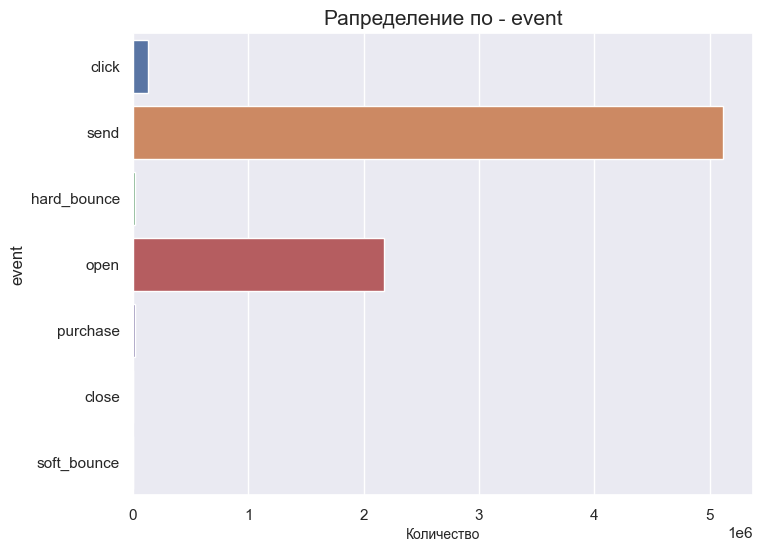

In [47]:
messages_push_diagram = messages[messages['channel'] == 'mobile_push']

direct_diagram(messages_push_diagram, 'event')

3 самые частыe действия которые пользователи делают с пуш уведомлениями - send, open, click

<b>Итог исследовательского анализа:</b> 
<br>Анализ проводился по таблицам <b>target</b> и <b>messages</b>
<br><b>target:</b>
<br>● quantity - в основном клиенты купили меньше 10 товаров, среднее количество - 2.6, медианное - 2
<br>● price - стоимость всех заказов редко привышает 5000р., среднее значение - 3297р., медианное - 2099р.
<br>● price_mean - обычно стоимость всех заказов около 2000р., среднее значение - 1499., медианное - 1274.
<br>● category_ids - 3 значения самых популярных категорий - 4, 5562, 2
<br>● number_days - количество дней между двумя датами очень-очень редко привышает 2
<br>● email - количество отправленных эмейл уведомлений практически не превышает 200 уведомлений
<br>● mobile_push - Количество отправленных пуш уведомлений практически не превышает 200 уведомлений
<br><b>messages:</b>
<br>● event - cамое частое действие которое пользователи делают с уведомлениями - send
<br>● 3 самые частыe действия которые пользователи делают с эмейл уведомлениями - send, open, click
<br>● 3 самые частыe действия которые пользователи делают с пуш уведомлениями - send, open, click

## <b>Матрица корреляции</b>

interval columns not set, guessing: ['client_id', 'target', 'quantity', 'price', 'price_mean', 'category_ids', 'number_days', 'email', 'mobile_push', 'click_emai', 'complain_email', 'hard_bounce_email', 'hbq_spam_email', 'open_email', 'purchase_email', 'send_email', 'soft_bounce_email', 'subscribe_email', 'unsubscribe_email', 'click_push', 'close', 'hard_bounce_push', 'open_push', 'purchase_push', 'send_push', 'soft_bounce_push']


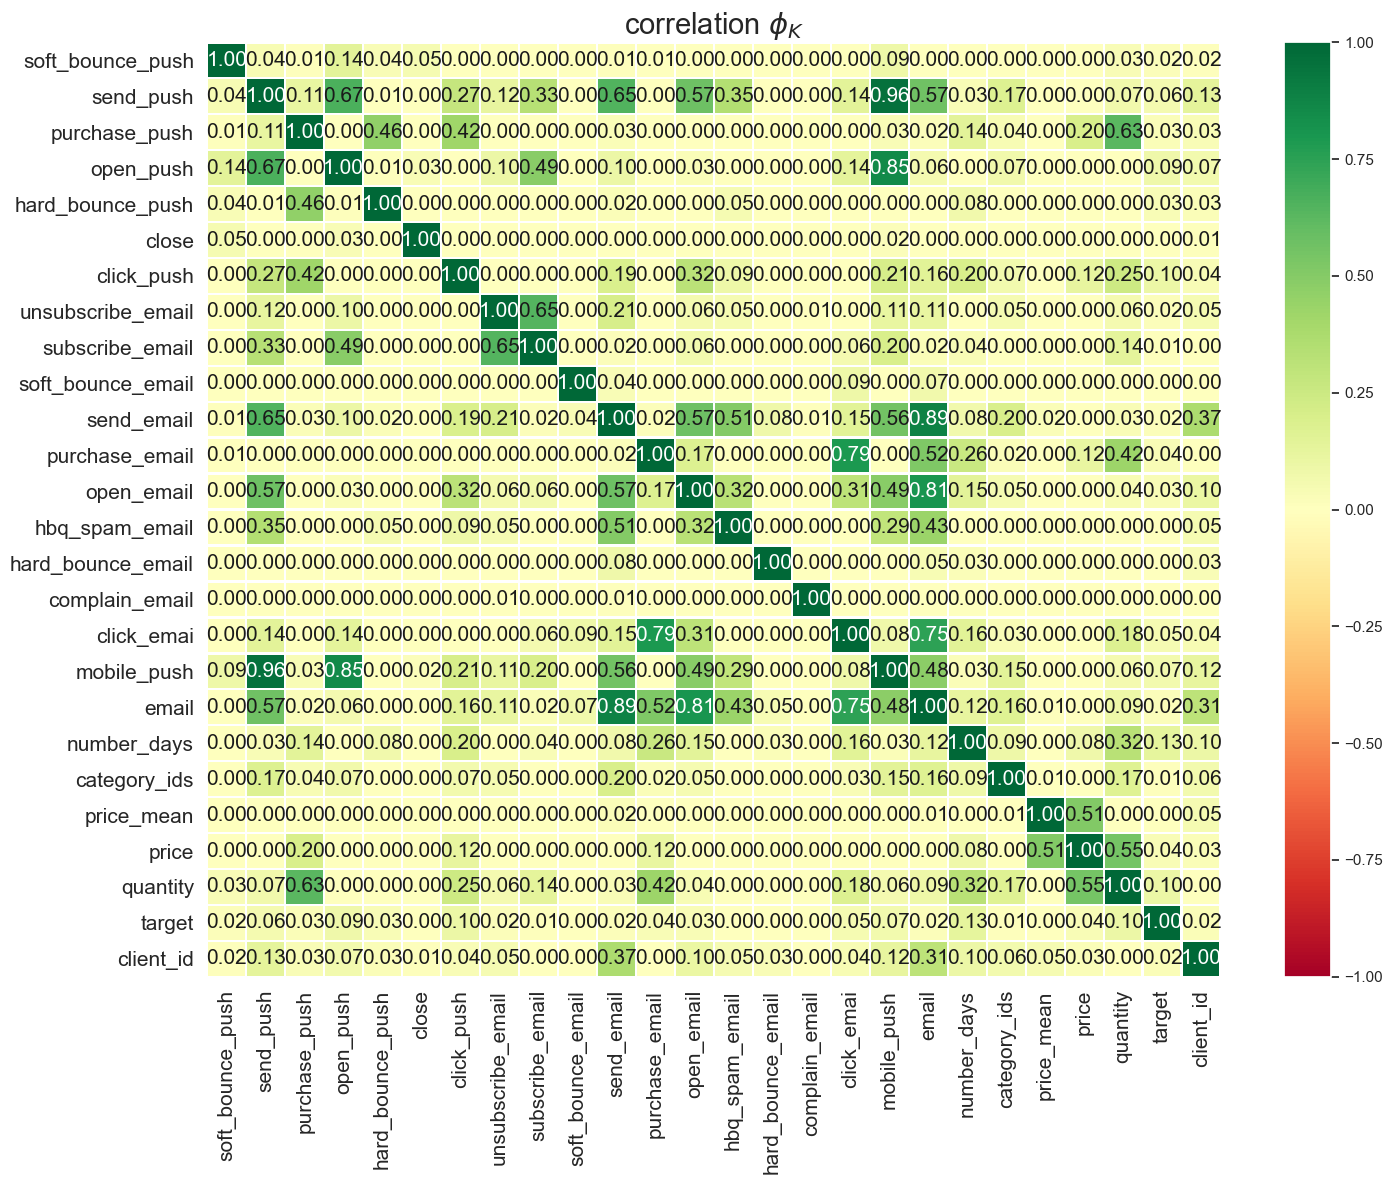

In [48]:
phik_overview = target.phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

<b>Итог матрицы корреляции:</b> 
<br>Много значений с кореляционным значением - 0
<br>Отрицательных значений нет
<br>Есть значения с большой корреляцией

## <b>Переработка данных</b>

In [49]:
X = target.drop(['client_id','target'], axis=1)
y = target['target']

X_train, X_test, y_train, y_test = train_test_split(X, y
    ,random_state = RANDOM_STATE
    ,stratify =y)

print(f"Строк в тренировочном датасете - {len(X_train)}") 
print(line)
print(f"Строк в тестовом датасете - {len(X_test)}")

Строк в тренировочном датасете - 31486
------------------------------------------------------------------------------------------------------------------------------------
Строк в тестовом датасете - 10496


In [50]:
num_col_names = X.columns.tolist()

In [51]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_col_names)
    ], 
    remainder='passthrough'
) 

In [52]:
pipe_final= Pipeline(
    [('preprocessor', data_preprocessor),
     ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])

## <b>Обучение моделей</b>

In [53]:
param_grid =[
    {'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
     'models__C': range(3,6),
     'preprocessor__num': [StandardScaler(), 'passthrough']},
    {'models': [KNeighborsClassifier()],
     'models__n_neighbors': range(5,10),
     'preprocessor__num': [StandardScaler(), 'passthrough']},
    {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': range(4, 10),
     'models__max_features': range(4,10),
     'preprocessor__num': [StandardScaler(), 'passthrough']},
    {'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)],
     'models__iterations': range(20, 200),
     'models__max_depth': range(4, 10),
     'models__bagging_temperature': range(1,2),
     'preprocessor__num': [StandardScaler(), 'passthrough']},
    {'models': [XGBClassifier(scale_pos_weight=1,subsample=0.8, colsample_bytree=0.8,gamma=0)],
     'models__max_depth': range(4,8),
     'preprocessor__num': [StandardScaler(), 'passthrough']}]

In [54]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1)

In [55]:
%%time

randomized_search.fit(X_train, y_train)

CPU times: total: 13.5 s
Wall time: 4min 36s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['quantity',
                                                                                'price',
                                                                                'price_mean',
                                                                                'category_ids',
                                                                                'number_days',
                                                                                'email',
                                                                                'mobil

In [56]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print(line)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['quantity', 'price',
                                                   'price_mean', 'category_ids',
                                                   'number_days', 'email',
                                                   'mobile_push', 'click_emai',
                                                   'complain_email',
                                                   'hard_bounce_email',
                                                   'hbq_spam_email',
                                                   'open_email',
                                                   'purchase_email',
                                                   'send_email',
                                                   'soft_bounce_email',
              

In [57]:
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba[:,1]), 2)}')

Метрика ROC-AUC на тестовой выборке: 0.71


Решил проверить стонет ли показатель ROC-AUC выше если я удалю те значения редкие значения действий с уведомлением и оставлю только по 3 для каждого - send, open, click

In [58]:
columns = ['quantity', 'price', 'price_mean', 'category_ids', 'number_days', 
           'email', 'mobile_push', 'click_emai', 'click_push', 'open_email', 
           'open_push', 'send_email', 'send_push']

short_X_train = X_train[columns]
short_X_test = X_test[columns]

short_data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), columns)
    ], 
    remainder='passthrough'
) 

short_pipe_final= Pipeline(
    [('preprocessor', short_data_preprocessor),
     ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])

randomized_search = RandomizedSearchCV(
    short_pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1)

randomized_search.fit(short_X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print(line)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

short_y_test_pred = randomized_search.predict(short_X_test)
short_y_test_proba = randomized_search.predict_proba(short_X_test)
print(line)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, short_y_test_proba[:,1]), 2)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['quantity', 'price',
                                                   'price_mean', 'category_ids',
                                                   'number_days', 'email',
                                                   'mobile_push', 'click_emai',
                                                   'click_push', 'open_email',
                                                   'open_push', 'send_email',
                                                   'send_push'])])),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x000001CA83081F40>)])
------------------------------------------------------------------------------------------------------------------------------------
Метрика лучшей модели 

## <b>Итог</b>

<br>Была проведена загрузка и изучение данных где оказалось что в таблицах <b>purchases</b> и <b>messages</b> были дубликаты. Пропусков не было ни в одной таблице.
<br>Была проведена переработка данных, где были удалены дубликаты а также к таблице <b>targget</b> присоеденены следующие столбцы:
<br>● quantity - количество всех товаров для каждого пользователя
<br>● price - сумма всех товаров для каждого пользователя
<br>● price_mean - средняя сумма всех товаров для каждого пользователя
<br>● category_ids - самая частая категория для каждого клиента
<br>● number_days - количество дней между первой и последней покупкой
<br>● email - количество уведомлений, отправленных в виде эмейла
<br>● mobile_push - количество уведомлений, отправленных в виде пуш
<br>● Агрегация <b>client_id</b>  дням с учетом событий и каналов рассылки
<br>Был проведен исследовательский анализ данных по двум талицам <b>targget</b> и <b>messages</b>, где выяснелось:
<br><b>target:</b>
<br>● quantity - в основном клиенты купили меньше 10 товаров, среднее количество - 2.6, медианное - 2
<br>● price - стоимость всех заказов редко привышает 5000р., среднее значение - 3297р., медианное - 2099р.
<br>● price_mean - обычно стоимость всех заказов около 2000р., среднее значение - 1499., медианное - 1274.
<br>● category_ids - 3 значения самых популярных категорий - 4, 5562, 2
<br>● number_days - количество дней между двумя датами очень-очень редко привышает 2
<br>● email - количество отправленных эмейл уведомлений практически не превышает 200 уведомлений
<br>● mobile_push - Количество отправленных пуш уведомлений практически не превышает 200 уведомлений
<br><b>messages:</b>
<br>● event - cамое частое действие которое пользователи делают с уведомлениями - send
<br>● 3 самые частыe действия которые пользователи делают с эмейл уведомлениями - send, open, click
<br>● 3 самые частыe действия которые пользователи делают с пуш уведомлениями - send, open, click
<br>Был созда пайплайн с 4 моделями:
<br>● LogisticRegression
<br>● KNeighborsClassifier
<br>● DecisionTreeClassifier
<br>● CatBoostClassifier
<br>● XGBClassifier
<br>Обучение проводилось в 2 раза. Сначала обучение было на созданой ранее таблице <b>target:</b> а второе обучение проводилось на таблице где были удалены столбцы с редкими значениями состоящими из агрегации <b>client_id</b>  по дням с учетом событий и каналов рассылки:
<br>● Метрика ROC-AUC на полной таблице - 0.71
<br>● Метрика ROC-AUC на полной укороченной таблице - 0.73